In [1]:
import sys
import os
import ssm
import pickle

import numpy                   as      np
import pandas                  as      pd

import matplotlib              as      mpl
import matplotlib.pyplot       as      plt
import seaborn                 as      sns

from   einops                  import  rearrange
from   utils                   import  load_data
from   scipy.interpolate       import  interp1d

import statsmodels.api         as      sm
import statsmodels.formula.api as      smf

from utils                     import  process_data
sns.set_style("white")
#sns.set_context("talk")

### Load data from ARHMM analyses

In [2]:
## Principal movements
# load pre-calculated PM data (from 100 random subset)
principal_movements = np.load('outputs/principal_movements_15components.npy')
variance_explained = np.load('outputs/principal_movements_explained_variance_15components.npy')
subject_timeseries = np.load('outputs/principal_movements_timeseries_15components.npy')
subject_norms = np.load('outputs/subject_data_norms.npy')
subject_means = np.load('outputs/subject_data_means.npy')
median_position = np.load('outputs/subject_data_median_position.npy')
# tweak positions for display
median_position_tweak = median_position.copy()
median_position_tweak[13] = median_position_tweak[13] * 1.3
median_position_tweak[27] = median_position_tweak[27] * 1.2

## ARHMM model
# load average model
with open('outputs/average-model.pkl', 'rb') as f:
    model = pickle.load(f)

## Processed subject data
data = np.load('outputs/all_model_data.npy')

## Calculate states for each subject from average model
# get states for each subject
subject_states = [model.most_likely_states(d) for d in data]
# save subject_states
np.save('outputs/all_subject_states.npy', subject_states)

## load subject info
info = pd.read_csv('outputs/all_subject_info.csv')

### Principal movements
Summary plots for each principal movement (based on a random subset of n=100)

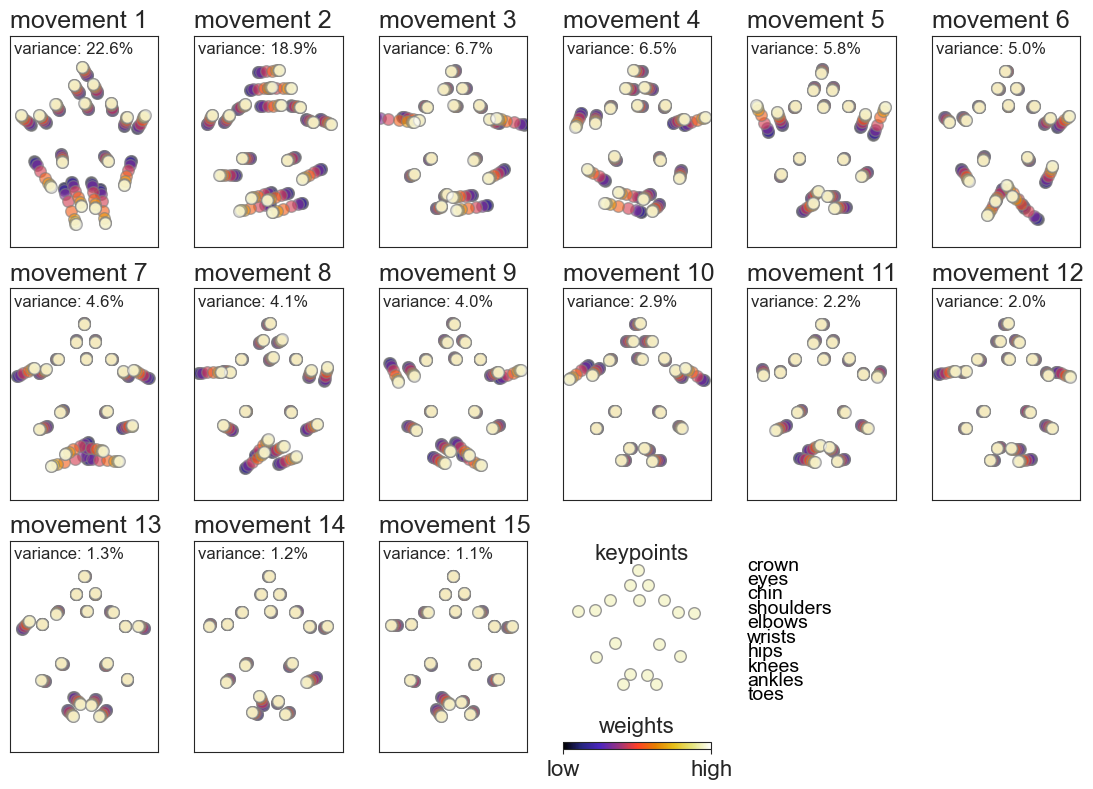

In [3]:
# plot movement range for each principal movement
num_points = 10 # number of points to plot
fig, axs = plt.subplots(3,6, figsize=(11, 8))
axs = axs.reshape(-1)
pal = 'CMRmap'
colors = mpl.colormaps[pal].resampled(num_points)

# for each of the PMs
for component in np.arange(15):
    
    # define range of weights
    min_comp = np.percentile(subject_timeseries[:,component], 1)
    max_comp = np.percentile(subject_timeseries[:,component], 99)

    z = 1/(1 + np.exp(-np.linspace(-5,5,num_points))) 
    z = z * (max_comp - min_comp) + min_comp
    z = np.concatenate((z, z[::-1]))

    # reconstruct movements across range of weights
    movement_pattern = z[:,np.newaxis].dot(principal_movements[component,:][np.newaxis,:])
    recon_movement = np.mean(subject_means, axis=0) + (np.mean(subject_norms, axis=0) * movement_pattern) 
    
    # plot movements
    recon_movement = recon_movement[:,:36] + median_position_tweak
    for i in np.arange(num_points):
        axs[component].scatter(recon_movement[i,1::2], -recon_movement[i,::2], 
                               facecolor=colors(i), edgecolor='grey', s=70, alpha=.6)
        axs[component].set_xticklabels([])
        axs[component].set_yticklabels([])
        
    axs[component].set_title('movement {:}'.format(component+1), fontsize=18, loc='left')
    axs[component].text(-52, 90, 'variance: {:.1f}%'.format(variance_explained[component]*100), fontsize=12)
    axs[component].set_xlim(-55, 55)
    axs[component].set_ylim(-130, 110)

# key for median position
lab_colors = mpl.colormaps[pal].resampled(20)
axs[-3].scatter(median_position_tweak[1::2], -median_position_tweak[::2], 
                           facecolor=lab_colors(18), edgecolor='grey', s=70, alpha=.8)
axs[-3].text(-32, 85, 'keypoints', fontsize=16)
axs[-3].set_xlim(-55, 55)
axs[-3].set_ylim(-120, 110)

# add colorbar for PC weights
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=pal), ax=axs[-3], orientation='horizontal',
                    ticks=[0, 1], location='bottom', fraction=0.05)
cbar.ax.set_xticklabels(['low', 'high'], fontsize=16) 
cbar.ax.set_xlabel('weights', fontsize=16, labelpad=-45) 

# annotations
for i in [-1, -2, -3]:
    sns.despine(ax=axs[i], left=True, bottom=True)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
axs[-2].set_xlim(-60, 55)
axs[-2].set_ylim(-120, 100)

# keypoint labels
FNT=14
axs[-2].text(-60, 70, 'crown', fontsize=FNT, c='black')
axs[-2].text(-60, 55, 'eyes', fontsize=FNT, c='black')
axs[-2].text(-60, 40, 'chin', fontsize=FNT, c='black')
axs[-2].text(-60, 25, 'shoulders', fontsize=FNT, c='black')
axs[-2].text(-60, 10, 'elbows', fontsize=FNT, c='black')
axs[-2].text(-60, -5, 'wrists', fontsize=FNT, c='black')
axs[-2].text(-60, -20, 'hips', fontsize=FNT, c='black')
axs[-2].text(-60, -35, 'knees', fontsize=FNT,c='black')
axs[-2].text(-60, -50, 'ankles', fontsize=FNT, c='black')
axs[-2].text(-60, -65, 'toes', fontsize=FNT, c='black')


plt.tight_layout()
plt.savefig('figures/principal-movements.png', dpi=300)

### Goodness-of-fit

In [4]:
all_results = pd.read_csv('outputs/cross-validation-results.csv')
all_results['models'] = all_results['obs_model'] + ['_'] + all_results['lag'].astype(str)
fig, ax = plt.subplots(1,1, figsize=(6,4))

labels = {'ar_1.0': 'AR(1)HMM', 'ar_2.0': 'AR(2)HMM', 'gaussian_0.0': 'HMM', 'full_nan' : 'GMM'}

sns.lineplot(x = 'states', y = 'test_av_LL', hue='Models', palette='Paired', data=all_results.assign(Models=all_results['models'].map(labels)), ax=ax)
g  = ax.legend(fontsize=13)

ax.set_ylabel('average log-likelihood \n (held out data)', fontsize=16)
ax.set_xlabel('number of states', fontsize=16)
ax.tick_params('both', labelsize=14)

plt.tight_layout()
plt.savefig('figures/goodness-of-fit.png', transparent=False, dpi=300)

### Model samples
Draw multivariate timeseries samples from the average fitted model and compare to empirical data from a random subject.

In [5]:
# get model samples from fitted model
synthetic_samples = model.sample(1899)[1][100:] # drop first 100 volumes for stability

# get shape values from data
num_subjects, num_timepoints, num_features = np.shape(data)

# plot
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=False, sharey=True)

# choose random subect
rand_idx = np.random.choice(np.arange(np.shape(data)[0]), size=1)

# plot principal movement weights
# take first 500 timesteps for plot, add an offset for each feature
sns.lineplot(np.arange(num_features)+np.squeeze(data[rand_idx])[:500,:], lw=1.5, dashes=False, ax=axs[0], legend=False, palette=pal)
axs[0].set_ylim(-2,19)

# plot synthetic sample weights from fitted model
sns.lineplot((np.arange(num_features)+synthetic_samples)[:500,:], lw=1.5, dashes=False, ax=axs[1], legend=False, palette=pal)

# set titles
axs[0].set_title('data samples', fontsize=22, loc='left', pad=-8)
axs[1].set_title('model samples', fontsize=22, loc='left', pad=-8)

# labels
for ax in axs:
    ax.set_ylim(-2,19)
    ax.set_xlim(0,500)
    ax.set_xlabel('timesteps', fontsize=18, loc='left', labelpad=-4.5)
    ax.set_ylabel('movements', fontsize=18, labelpad=-0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('figures/model-samples.png'.format(f), transparent=False, dpi=300)


### Feature distributions
Compare distribution of values for each movement feature in empirical data and synthetic samples

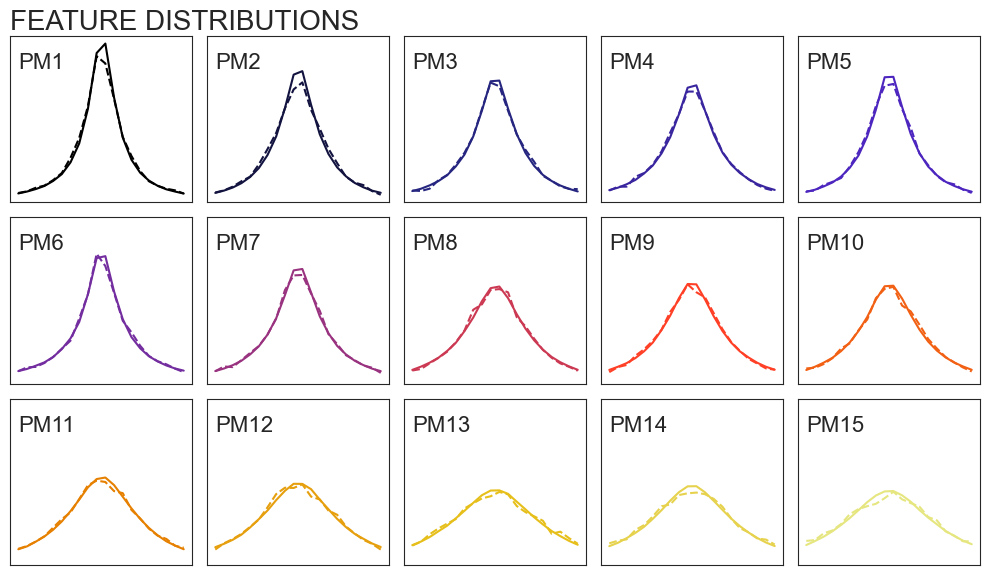

In [6]:
# flatten data
all_data = rearrange(data, 's t f -> (s t) f')

# get model samples (large number to estimate distributions)
synthetic_samples = model.sample(10000)[1]

# distribution of values for each feature (principal movement)
fig, axs = plt.subplots(3, 5, figsize=(10, 6), sharey=True)
axs = axs.reshape(-1)
num_bins = 20

colors = mpl.colormaps[pal].resampled(17)
# for each movement
for i in range(num_features):
    
    # plot histograms of PM weights for synthetic and empirical data
    synth_hist = (np.histogram(synthetic_samples[:, i], bins=num_bins, range=(np.percentile(synthetic_samples,5), np.percentile(synthetic_samples, 95)), density=True)[0])
    empirical_hist = (np.histogram(all_data[:, i], bins=num_bins, range=(np.percentile(synthetic_samples,5), np.percentile(synthetic_samples, 95)), density=True)[0])

    axs[i].plot(synth_hist, color=colors(i),
            linewidth=1.5, linestyle='--')
    
    axs[i].plot(empirical_hist, color=colors(i),
        linewidth=1.5)

    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].text(0.05, 1.0, 'PM{:}'.format(i+1), fontsize=16)

# titles
plt.suptitle('FEATURE DISTRIBUTIONS', horizontalalignment='center', x=0.19, y=.95, fontsize=20)
plt.tight_layout()
plt.savefig('figures/model-feature-distributions.png', transparent=False, dpi=300)


### State differences
Plots of movement data in each subject overlaid with most likely state. Top row shows the most likely state (top) and movement amplitudes (bottom) for each frame. Middle row shows frames ordered by state. Bottom row shows state occupancy. Each column is a different subject.

/tmp/ipykernel_16319/963052069.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


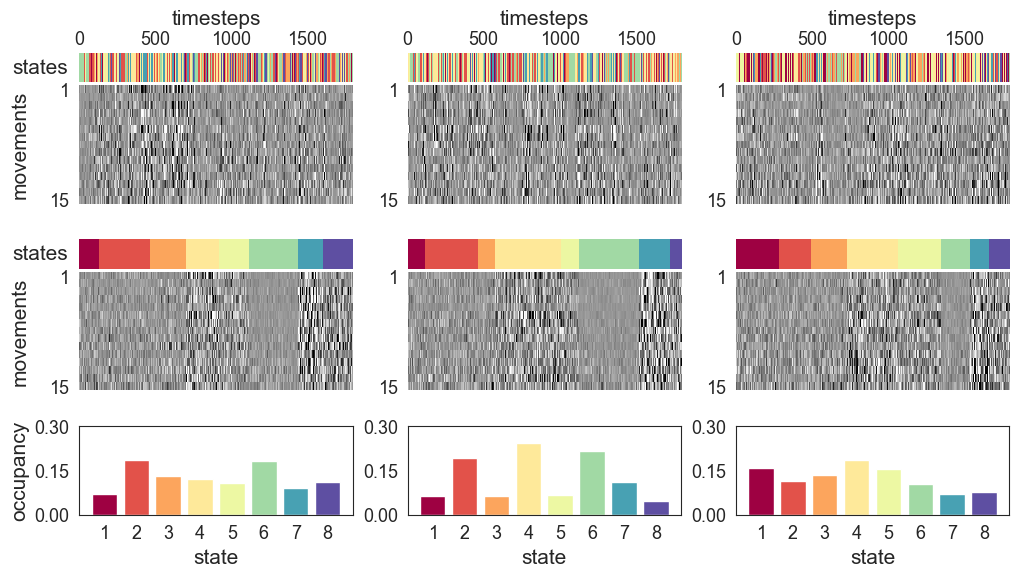

In [7]:
FNT=15
fig, ax = plt.subplots(7, 3, figsize=(12,6), gridspec_kw=dict(height_ratios=[1, 4, 1, 1, 4, 1, 3], hspace=0.05))
ax = ax.reshape(-1)
colors = [plt.get_cmap('Spectral', 8)(i) for i in np.arange(8)]

# subect 1 - 
sub = 0
# state sequence
ss = subject_states[sub]
# movement data (normalise for display)
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
# count frames in each state
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[0].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[3].matshow(sdata,  aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[9].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral',)
ax[12].matshow(sdata[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[18].bar(svalues, scounts, color=colors)

# subect 2
# as above
sub = 1
ss = subject_states[sub]
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[1].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[4].matshow(data[1].T,  aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[10].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral')
ax[13].matshow(data[1].T[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[19].bar(svalues, scounts, color=colors)

# subect 3
# as above
sub = 2
ss = subject_states[sub]
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[2].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[5].matshow(data[2].T,  aspect='auto',cmap='Greys', vmin=-3, vmax=3)
ax[11].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral')
ax[14].matshow(data[2].T[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[20].bar(svalues, scounts, color=colors)

# LABELS
ax[0].set_ylabel('states', rotation=0, labelpad=21, va='center', fontsize=FNT) 
ax[3].set_ylabel('movements', labelpad=14, fontsize=FNT)    
ax[9].set_ylabel('states', rotation=0, labelpad=21, va='center', fontsize=FNT)
ax[12].set_ylabel('movements', labelpad=14, fontsize=FNT)    

for axs in ax[:3]:
    axs.tick_params(axis='x', length=0)
    axs.set_xlabel('timesteps', fontsize=FNT)
    axs.xaxis.set_label_position('top') 
    axs.set_xticks((0, 500, 1000, 1500))
    axs.tick_params(axis='x', labelsize=FNT-2)
    axs.set_yticklabels([])
    
for axs in ax[6:12]:
    axs.set_yticklabels([])

for axs in ax[3:15]:
    axs.tick_params(axis='x', length=0)
    axs.set_xticklabels([])    

for axs in ax[3:6]:
    axs.set_yticks((0, 14))
    axs.set_yticklabels([1, 15], fontsize=FNT-2)    
    
for axs in ax[12:15]:
    axs.set_yticks((0, 14))
    axs.set_yticklabels([1, 15], fontsize=FNT-2)  

for axs in ax[15:18]:
    axs.tick_params(axis='both', length=0)
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    
for axs in ax[18:]:
    axs.set_ylim(0,.3)
    axs.set_yticks((0, 0.15, 0.3))
    axs.tick_params(axis='y', labelsize=FNT-2)
    axs.set_xticks(np.arange(8))
    axs.set_xticklabels(np.arange(8)+1, fontsize=FNT-2)
    axs.set_xlabel('state', fontsize=FNT)

for axs in ax[:18]:
    sns.despine(ax=axs, left=True, bottom=True)

ax[18].set_ylabel('occupancy', fontsize=FNT)

plt.tight_layout()
plt.savefig('figures/subject-state-occupancy.png', dpi=300, transparent=False)

### Average state occupancy
Mean state occupancy (how many frames in each state) for each subject

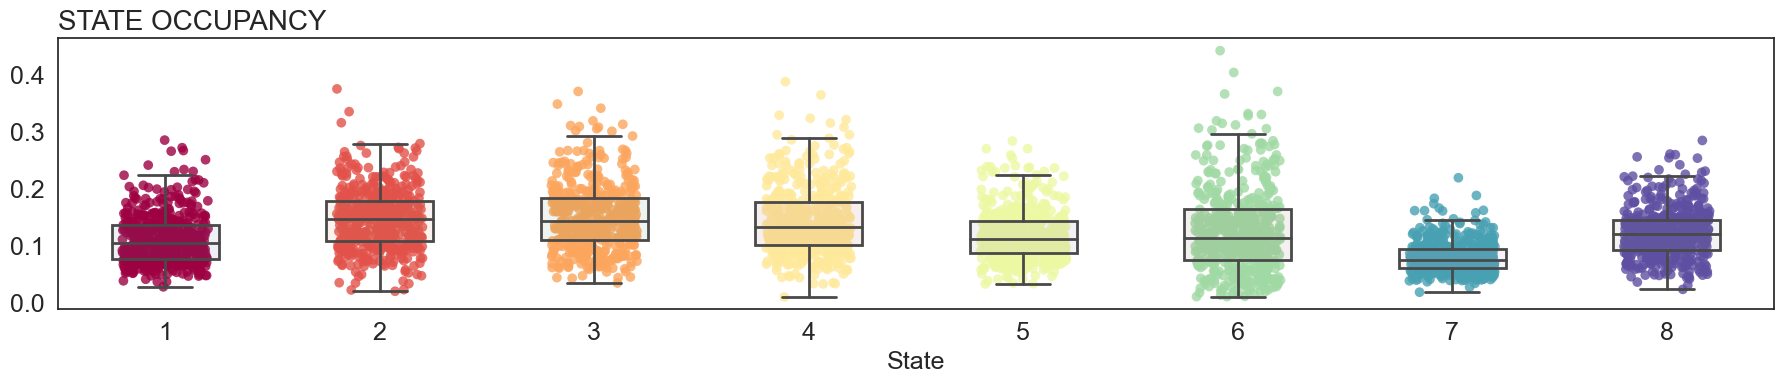

In [8]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig, ax = plt.subplots(1, 1, figsize=(18,4))

# count the frequency of each state
svalues = []
scounts = []
for s in subject_states:
    v, c = np.unique(s, return_counts=True)
    svalues.append(v)
    scounts.append(c/sum(c))
    
# plot
b = sns.boxplot(x=np.stack(svalues).reshape(-1)+1, y=np.stack(scounts).reshape(-1), linewidth=2, width = 0.5, fliersize=0)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))   
    
sns.stripplot(x=np.stack(svalues).reshape(-1), y=np.stack(scounts).reshape(-1), 
              native_scale=True, hue=np.stack(svalues).reshape(-1), zorder=0,
              s=7, palette=colors, alpha=0.8, jitter=0.2, linewidth=0, edgecolor='grey' ,legend=False)

# labels
ax.set_title('STATE OCCUPANCY', fontsize=20, loc='left')
ax.set_xlabel('State', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.savefig('figures/average-state-occupancy.png', dpi=300, transparent=False)

### Changes in state occupancy over time
For each subject, state occupancy (# frames in each state) is plotted against age, videos in the same subject are joined by a line

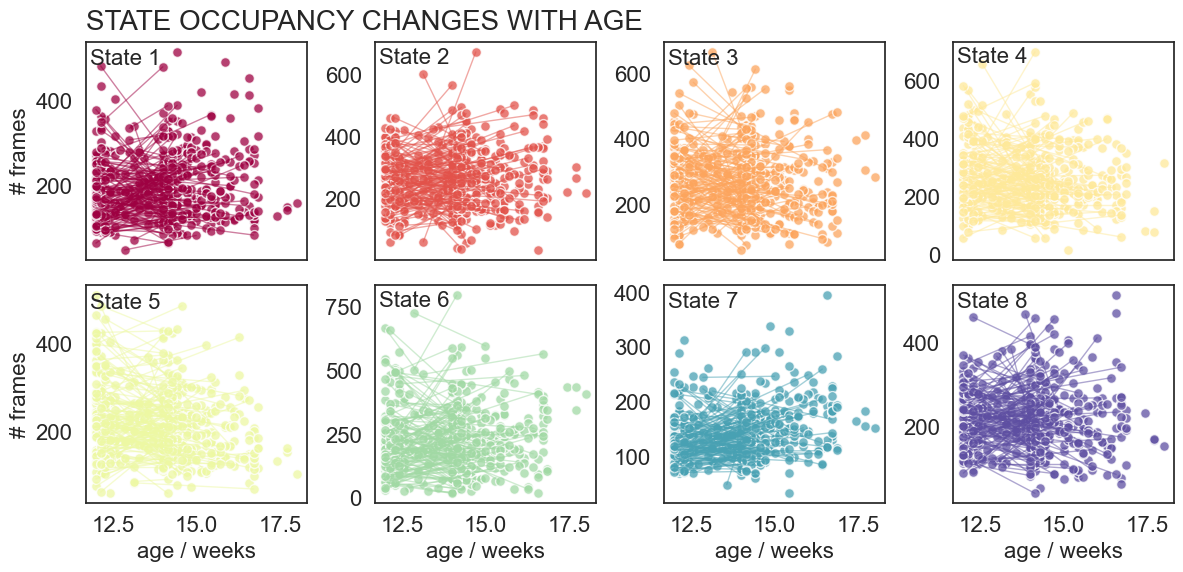

In [9]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# get age
ages = info.age_at_vid.values
# reset index to account for the excluded videos
reset_info = info.reset_index()

# specify the number of states
num_states = 8

# create the subplots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(12, 6))

# plots
all_counts = []
for s in range(num_states):
    # count the occurrences of the state in each subject
    counts = [sum(state == s for state in subject_states[i]) if any(state == s for state in subject_states[i]) else 0 for i in range(len(ages))]
    # keep counts for all states
    all_counts.append(counts)
    # scatter plot
    axs[s//4][s%4].scatter(ages, counts, color=colors[s], s=50, edgecolor='white', alpha=0.75)
    axs[s//4][s%4].tick_params(axis='both', labelsize=16)
    
    # join repeated videos with a line
    for idx in reset_info['participant'].unique():
        df_idx = reset_info[reset_info['participant'] == idx].index.values
        axs[s//4][s%4].plot([ages[d] for d in df_idx], [counts[d] for d in df_idx], lw=1, alpha=.5, color=colors[s])

# labels
for s in range(num_states):
    x_loc = axs[s//4][s%4].get_xlim()[0]
    x_loc = x_loc + x_loc * .01
    y_loc = axs[s//4][s%4].get_ylim()[1]
    y_loc = y_loc - y_loc * .1
    axs[s//4][s%4].text(x_loc, y_loc , 'State {:}'.format(s+1), fontsize=16)

for ax in axs[1]:    
    ax.set_xlabel('age / weeks', fontsize=16)
axs[0][0].set_ylabel('# frames', fontsize=16)
axs[1][0].set_ylabel('# frames', fontsize=16)

plt.suptitle('STATE OCCUPANCY CHANGES WITH AGE', horizontalalignment='center', x=0.31, y=.95, fontsize=20)

plt.tight_layout()
plt.savefig('figures/state-occupancy-by-age.png', dpi=300, transparent=False)

### Statistics
Test associations between state occupancy and age using linear mixed effects models

In [10]:
all_counts = pd.DataFrame(np.stack(all_counts).T)
all_counts.columns = ['state{:}'.format(i+1) for i in np.arange(8)]

state_info = pd.concat((reset_info, all_counts), axis=1)
state_info

index  idnum  participant  timepoint         group  final_gma  \
0        0      2       162003         14       preterm  normal GM   
1        1      8       162009         14       preterm  normal GM   
2        2     16       162017         12       preterm  normal GM   
3        3     21       162022         14       preterm  normal GM   
4        4     22       162023         12       preterm  normal GM   
..     ...    ...          ...        ...           ...        ...   
481    481    574       167212         12  term control  normal GM   
482    482    574       167212         14  term control  normal GM   
483    483    577       167215         12  term control  normal GM   
484    484    577       167215         14  term control  normal GM   
485    485    579       167217         14  term control  normal GM   

      gma_vid_cat gma_vid_score cp_diagnosis_2year  gmfcs  ...  age_at_vid  \
0       continous     normal GM              No CP    0.0  ...   14.857142   
1       continous     normal GM                NaN    NaN  ...   15.428572   
2       continous     normal GM              No CP    0.0  ...   12.428572   
3       continous     normal GM              No CP    0.0  ...   16.000000   
4       continous     normal GM              No CP    0.0  ...   13.714286   
..            ...           ...                ...    ...  ...         ...   
481     continous     normal GM              No CP    0.0  ...   12.857142   
482  intermittent     normal GM              No CP    0.0  ...   15.000000   
483     continous     normal GM              No CP    0.0  ...   12.000000   
484     continous     normal GM              No CP    0.0  ...   14.142858   
485     continous     normal GM                NaN    NaN  ...   14.142858   

        video  state1  state2  state3  state4  state5 state6  state7  state8  
0    162003_2     129     336     238     219     191    325     163     198  
1    162009_2     113     344     114     434     119    391     202      82  
2    162017_1     282     208     241     333     281    190     127     137  
3    162022_2     175     169     400     188     215    270     147     235  
4    162023_1     225     375     209     290     359     72      98     171  
..        ...     ...     ...     ...     ...     ...    ...     ...     ...  
481  167212_1      50     193     132     200     139    728     245     112  
482  167212_2      84     189     243     192     134    598     247     112  
483  167215_1     379     159     351     147     308     40     119     296  
484  167215_2     193     333     289     206     289    143     134     212  
485  167217_2     217     218     368     261     211    197     130     197  

[486 rows x 26 columns]

In [11]:
fitted_models = []

# fit mixed effects model to each state occupancy: state ~ 1 + age + e
for state in all_counts.columns:
    age_model = smf.mixedlm('{:} ~ age_at_vid'.format(state), state_info, groups=state_info["participant"])

    age_model_fit = age_model.fit()
    print('')
    print('Model results: {:}'.format(state))
    print(age_model_fit.summary())
    fitted_models.append(age_model_fit)

    
# gather results
pvals = [m.pvalues[:2] for m in fitted_models]
coef = [m.params[:2] for m in fitted_models]
se = [m.bse[:2] for m in fitted_models]

# dataframes
coef = pd.DataFrame(coef)
coef = coef.melt(value_name='coef', var_name='modelterm')

se = pd.DataFrame(se)
se = se.melt(value_name='se', var_name='modelterm')

pvals = pd.DataFrame(pvals)
pvals = pvals.melt(value_name='pvals', var_name='modelterm')

states = pd.DataFrame(np.tile(np.arange(8)+1, 2))
states.columns = ['state']

model_results = pd.concat((states, coef, se, pvals), axis=1)
model_results = model_results.loc[:,~model_results.columns.duplicated()].copy()
model_results = model_results.sort_values(by='state').reset_index(drop=True)

# save out
model_results.to_csv('outputs/age-model-results.csv', index=None)
with open('outputs/age-mixed-models.pkl', 'wb') as fp:
    pickle.dump(fitted_models, fp)


Model results: state1
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: state1    
No. Observations: 486     Method:             REML      
No. Groups:       330     Scale:              3244.0622 
Min. group size:  1       Log-Likelihood:     -2785.6003
Max. group size:  2       Converged:          Yes       
Mean group size:  1.5                                   
--------------------------------------------------------
             Coef.   Std.Err.   z   P>|z| [0.025  0.975]
--------------------------------------------------------
Intercept    137.622   30.512 4.510 0.000 77.820 197.424
age_at_vid     4.652    2.157 2.157 0.031  0.425   8.879
Group Var   2928.742   13.703                           


Model results: state2
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: state2    
No. Observations: 486     Method:             REML      
No. Groups:       330     Scale:              5752.4471 
Min.

### Plot age effects with stats overlaid
as above but with model fit added

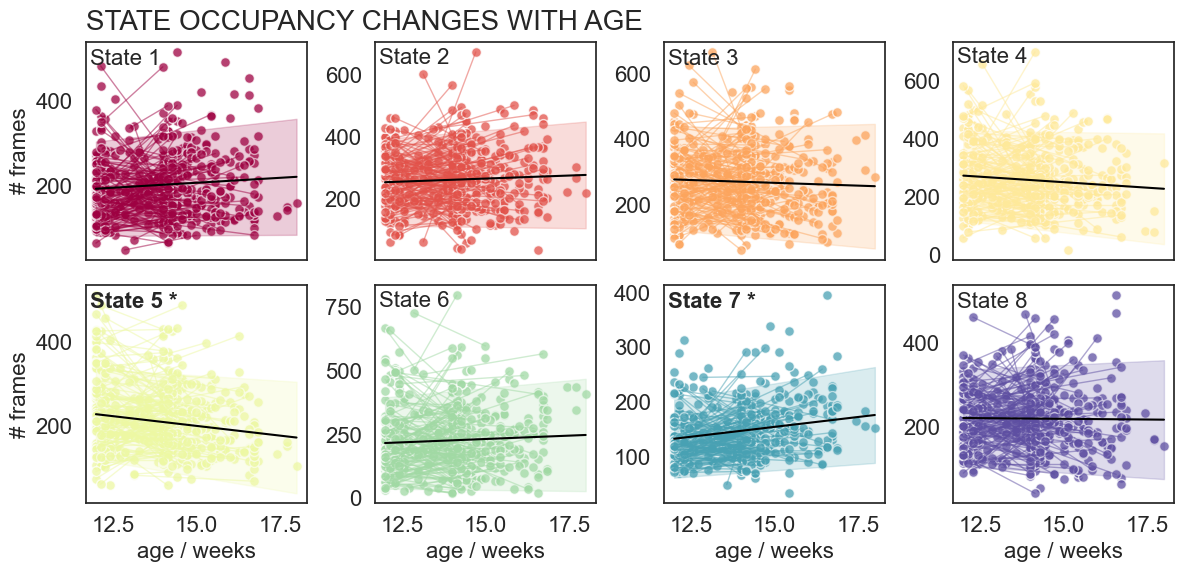

In [12]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# get age
ages = info.age_at_vid.values
# reset index to account for the excluded videos
reset_info = info.reset_index()

# specify the number of states
num_states = 8

# create the subplots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(12, 6))

# dummy data
age=np.linspace(min(ages), max(ages), 50)
group = ['162003'] * 50 # ignore in mode predictions
# dummy df for predictions
newx = pd.DataFrame((age, group)).T
newx.columns = ['age_at_vid', 'participant']
newx = newx.astype(dtype= {'age_at_vid':'float64',
                           'participant':'int64'})

# plots
for s in range(num_states):
    # count the occurrences of the state in each subject
    counts = [sum(state == s for state in subject_states[i]) if any(state == s for state in subject_states[i]) else 0 for i in range(len(ages))]

    # scatter plot
    axs[s//4][s%4].scatter(ages, counts, color=colors[s], s=50, edgecolor='white', alpha=0.75)
    axs[s//4][s%4].tick_params(axis='both', labelsize=16)
    
    # join repeated videos with a line
    for idx in reset_info['participant'].unique():
        df_idx = reset_info[reset_info['participant'] == idx].index.values
        axs[s//4][s%4].plot([ages[d] for d in df_idx], [counts[d] for d in df_idx], lw=1, alpha=.5, color=colors[s])

    # calculate model predictions and intervals
    predictions = fitted_models[s].predict(newx)
    lower = newx['age_at_vid'] * fitted_models[s].conf_int()[0]['age_at_vid'] + fitted_models[s].conf_int()[0]['Intercept'] 
    upper = newx['age_at_vid'] * fitted_models[s].conf_int()[1]['age_at_vid'] + fitted_models[s].conf_int()[1]['Intercept'] 

    axs[s//4][s%4].plot(newx['age_at_vid'], predictions, color='black')
    axs[s//4][s%4].fill_between(newx['age_at_vid'], lower, upper, edgecolor=None, color=colors[s], alpha=0.2)

# labels
for s in range(num_states):
    x_loc = axs[s//4][s%4].get_xlim()[0]
    x_loc = x_loc + x_loc * .01
    y_loc = axs[s//4][s%4].get_ylim()[1]
    y_loc = y_loc - y_loc * .1
    if fitted_models[s].pvalues['age_at_vid']<(0.05/8):
        axs[s//4][s%4].text(x_loc, y_loc , 'State {:} *'.format(s+1), fontsize=16, fontweight='bold')
    else:
        axs[s//4][s%4].text(x_loc, y_loc , 'State {:}'.format(s+1), fontsize=16)


for ax in axs[1]:    
    ax.set_xlabel('age / weeks', fontsize=16)
axs[0][0].set_ylabel('# frames', fontsize=16)
axs[1][0].set_ylabel('# frames', fontsize=16)

plt.suptitle('STATE OCCUPANCY CHANGES WITH AGE', horizontalalignment='center', x=0.31, y=.95, fontsize=20)

plt.tight_layout()
plt.savefig('figures/state-occupancy-by-age-with-stats.png', dpi=300, transparent=False)

### Additional stats models
State occupancy tested for assocations with birth status (preterm/term) and GMA outcome

y ~ group + GMA + age

In [13]:
# take GMA results from the latest video
gma_info = state_info.sort_values(by=['participant', 'timepoint']).groupby(by='participant').last().reset_index()
gma_info = gma_info[gma_info['final_gma'].isin(['normal GM', 'absent/abn GM'])]
final_gma_dict = dict(zip(gma_info['participant'], gma_info['final_gma']))

# use this score for all participants
state_info['final_gma_latest'] = state_info['participant'].map(final_gma_dict)
state_info.to_csv('outputs/state_info.csv', index=None)

In [14]:
fitted_models = []

outcome_info = state_info[~pd.isna(state_info['final_gma'])]

for state in all_counts.columns:
    all_model = smf.mixedlm('{:} ~ C(group) + age_at_vid + C(final_gma_latest)'.format(state), outcome_info, groups=outcome_info["participant"])

    all_model_fit = all_model.fit()
    print('')
    print('Model results: {:}'.format(state))
    print(all_model_fit.summary())
    fitted_models.append(all_model_fit)

# gather results
pvals = [m.pvalues[:4] for m in fitted_models]
coef = [m.params[:4] for m in fitted_models]
se = [m.bse[:4] for m in fitted_models]

# dataframes
coef = pd.DataFrame(coef)
coef = coef.melt(value_name='coef', var_name='modelterm')

se = pd.DataFrame(se)
se = se.melt(value_name='se', var_name='modelterm')

pvals = pd.DataFrame(pvals)
pvals = pvals.melt(value_name='pvals', var_name='modelterm')

states = pd.DataFrame(np.tile(np.arange(8)+1, 4))
states.columns = ['state']

model_results = pd.concat((states, coef, se, pvals), axis=1)
model_results = model_results.loc[:,~model_results.columns.duplicated()].copy()
model_results = model_results.sort_values(by='state').reset_index(drop=True)

# save out
model_results.to_csv('outputs/GMA-model-results.csv', index=None)
with open('outputs/GMA-mixed-models.pkl', 'wb') as fp:
    pickle.dump(fitted_models, fp)


Model results: state1
                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        state1    
No. Observations:          482            Method:                    REML      
No. Groups:                326            Scale:                     3267.8611 
Min. group size:           1              Log-Likelihood:            -2748.6607
Max. group size:           2              Converged:                 Yes       
Mean group size:           1.5                                                 
-------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                         124.663   32.454  3.841 0.000  61.054 188.272
C(group)[T.term control]           31.853    8.243  3.864 0.000  15.697  48.008
C(final_gma_latest)[T.normal GM]   -2.


Model results: state8
                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        state8    
No. Observations:          482            Method:                    REML      
No. Groups:                326            Scale:                     3817.7941 
Min. group size:           1              Log-Likelihood:            -2751.3540
Max. group size:           2              Converged:                 Yes       
Mean group size:           1.5                                                 
-------------------------------------------------------------------------------
                                  Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------------
Intercept                         222.964   33.441  6.667 0.000 157.421 288.508
C(group)[T.term control]           34.380    7.982  4.307 0.000  18.735  50.024
C(final_gma_latest)[T.normal GM]   -8.

Accounting for changes with age, there are significant differences in the amount of time preterm and term infants spend in different states  
GMA outcome is associated with time spent in state 7

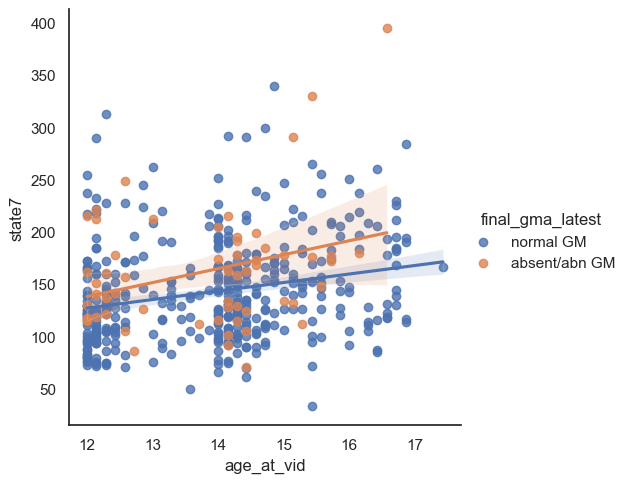

In [15]:
# scatter plot
sns.lmplot(x='age_at_vid', y='state7', hue='final_gma_latest', data=outcome_info)


State occupancy tested for assocations with birth status (preterm/term) and Bayley's outcome


In [16]:
fitted_models = []

outcome_info = state_info[~pd.isna(state_info['bay_mot_comp'])]

for state in all_counts.columns:
    all_model = smf.mixedlm('{:} ~ C(group) + age_at_vid + bay_mot_comp'.format(state), outcome_info, groups=outcome_info["participant"])

    all_model_fit = all_model.fit()
    print('')
    print('Model results: {:}'.format(state))
    print(all_model_fit.summary())
    fitted_models.append(all_model_fit)

# gather results
pvals = [m.pvalues[:4] for m in fitted_models]
coef = [m.params[:4] for m in fitted_models]
se = [m.bse[:4] for m in fitted_models]

# dataframes
coef = pd.DataFrame(coef)
coef = coef.melt(value_name='coef', var_name='modelterm')

se = pd.DataFrame(se)
se = se.melt(value_name='se', var_name='modelterm')

pvals = pd.DataFrame(pvals)
pvals = pvals.melt(value_name='pvals', var_name='modelterm')

states = pd.DataFrame(np.tile(np.arange(8)+1, 4))
states.columns = ['state']

model_results = pd.concat((states, coef, se, pvals), axis=1)
model_results = model_results.loc[:,~model_results.columns.duplicated()].copy()
model_results = model_results.sort_values(by='state').reset_index(drop=True)

# save out
model_results.to_csv('outputs/Bayley-MOT-model-results.csv', index=None)
with open('outputs/Bayley-MOT-mixed-models.pkl', 'wb') as fp:
    pickle.dump(fitted_models, fp)


Model results: state1
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     state1    
No. Observations:       456         Method:                 REML      
No. Groups:             302         Scale:                  3252.6162 
Min. group size:        1           Log-Likelihood:         -2592.3466
Max. group size:        2           Converged:              Yes       
Mean group size:        1.5                                           
----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z| [0.025  0.975]
----------------------------------------------------------------------
Intercept                 178.288   40.786  4.371 0.000 98.349 258.226
C(group)[T.term control]   31.658    8.451  3.746 0.000 15.095  48.221
age_at_vid                  2.826    2.180  1.296 0.195 -1.448   7.099
bay_mot_comp               -0.318    0.252 -1.263 0.207 -0.812   0.176



Model results: state8
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      state8    
No. Observations:      456          Method:                  REML      
No. Groups:            302          Scale:                   3819.1316 
Min. group size:       1            Log-Likelihood:          -2605.1040
Max. group size:       2            Converged:               Yes       
Mean group size:       1.5                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 185.481   42.098  4.406 0.000 102.971 267.991
C(group)[T.term control]   27.592    8.438  3.270 0.001  11.053  44.131
age_at_vid                 -1.188    2.298 -0.517 0.605  -5.692   3.316
bay_mot_comp                0.346    0.252  1.375 0.169  -

## Comparison of state characteristics


removing 1 outlier video
removing 1 videos with no age at video


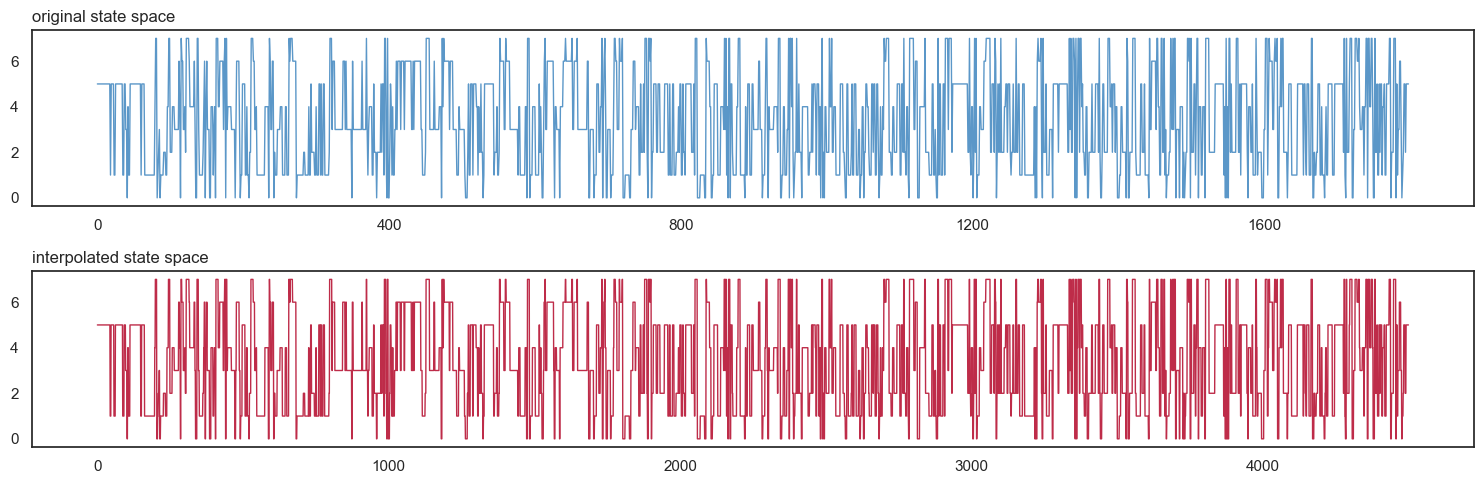

In [17]:
state_space = np.load('outputs/all_subject_states.npy')

# data in bodypoint space
trajectory_data, info = load_data('trajectory_data/')
# process without downsampling 
processed_data, outliers = process_data(trajectory_data, do_filter=True, new_frequency = 25, frequency=25)

# add mean position back to processed data
normalised_processed_data = processed_data - np.mean(processed_data, 1)[:,np.newaxis,:] # remove subject specific mean
normalised_processed_data = normalised_processed_data + np.mean(trajectory_data, (0,1))[np.newaxis,np.newaxis,:] # add in group average position

# interpolate statespace
f_original = np.arange(0,1799)
f_new = np.linspace(0,1798,4500)

state_space_long = []
for s in state_space:
    interpf = interp1d(f_original, s, kind = 'nearest')
    state_space_long.append(interpf(f_new))
state_space_long = np.array(state_space_long)

fig, ax = plt.subplots(2,1,figsize=(15,5))
ax[1].plot(state_space_long[0,:], lw=1, c='#be2c49')
ax[0].plot(np.arange(1799)*2.5, state_space[0,:], lw=1, c='#5b97c8')
ax[1].set_title('interpolated state space', loc='left')
ax[0].set_title('original state space', loc='left')
ax[0].set_xticks((0,1000,2000,3000,4000), labels=(np.array((0,1000,2000,3000,4000))/2.5).astype(int))
plt.tight_layout()

### Distribution of bodypoint position in each state

plotting


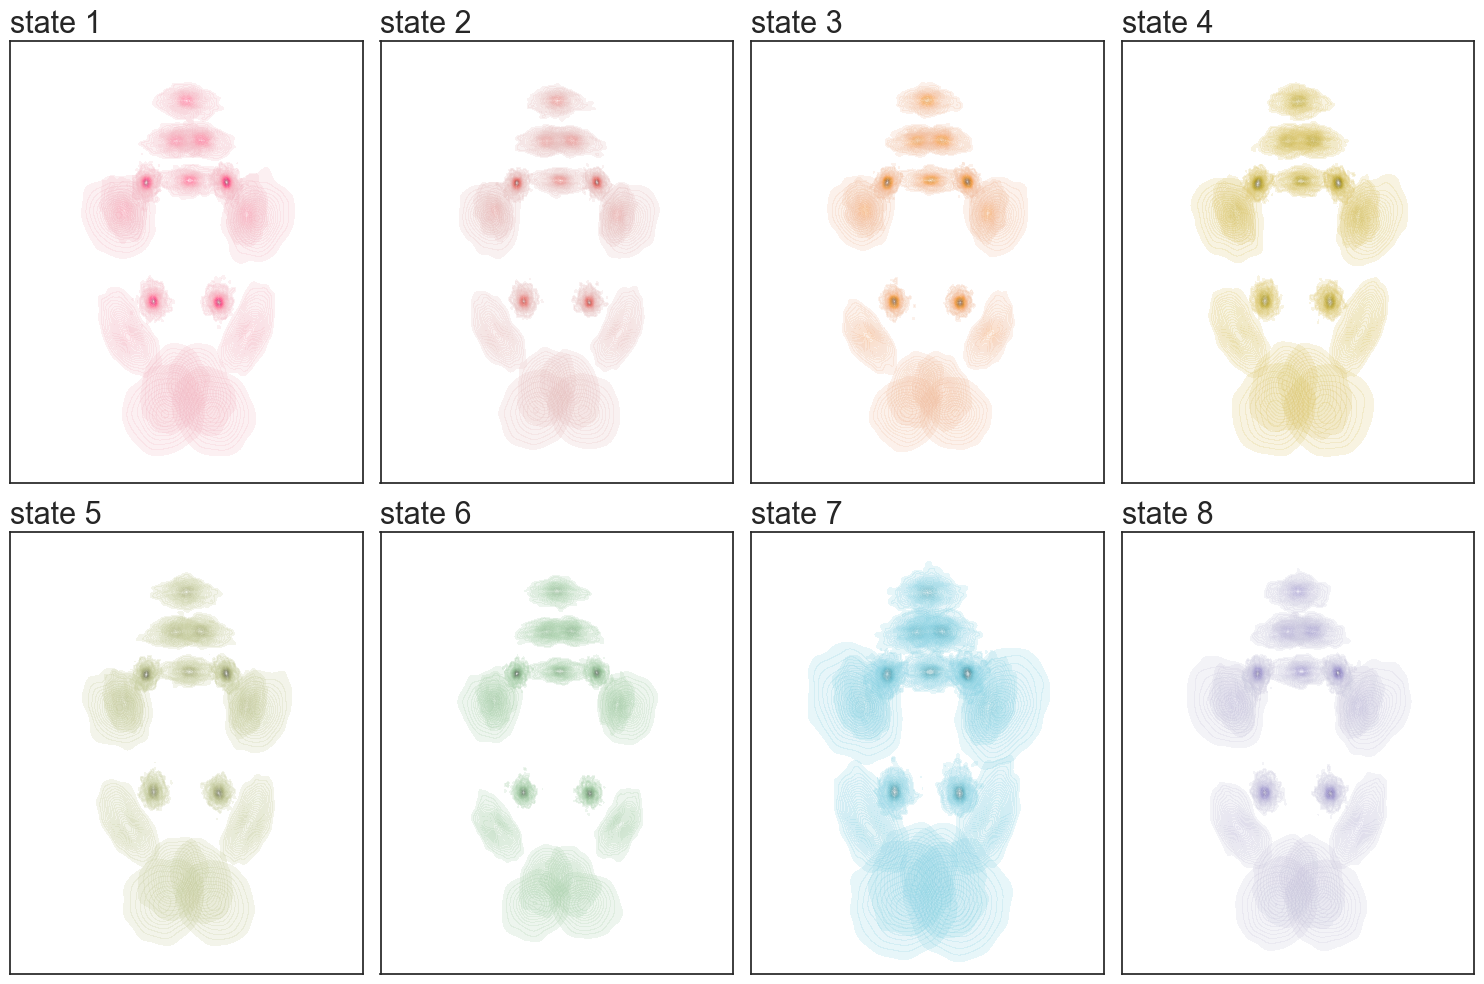

In [18]:
d = rearrange(normalised_processed_data, 's t f -> (s t) f')
s = rearrange(state_space_long, 's t -> (s t)')

fig, ax = plt.subplots(2, 4, figsize=(15,10), sharex=True, sharey=True)

print('plotting')
for n, a in enumerate(ax.reshape(-1)):
    data_x = -d[s==n,::2]
    data_y = d[s==n,1::2]
    
    # random subsample to reduce computation
    rand_idx = np.random.choice(np.arange(np.shape(data_x)[0]), size=5000, replace=False)
    data_x = data_x[rand_idx, :]
    data_y = data_y[rand_idx, :]

    # dataframes
    x = pd.DataFrame(data_x.T)
    x.insert(0, 'dir','x')
    x.insert(0,'bp',np.arange(18))
    x = x.melt(id_vars=['bp','dir'],var_name='tp',value_name='coord_x')

    y = pd.DataFrame(data_y.T)
    y.insert(0, 'dir','y')
    y.insert(0,'bp',np.arange(18))
    y = y.melt(id_vars=['bp','dir'],var_name='tp',value_name='coord_y')

    xy = pd.concat((x,y),axis=1)
    xy = xy.T.drop_duplicates().T

    # plots
    sns.kdeplot(x='coord_y', y='coord_x', data=xy, 
                levels=50, fill=True, alpha=0.2, hue='bp', 
                legend=False, ax=a, palette=[colors[n]]*18)
    
    # extras
    a.set_title('state {:}'.format(n+1), loc='left', fontsize=22)
    a.set_ylim(-120,100)
    a.set_xlim(-90,90)
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xticklabels('')
    a.set_yticklabels('')
    
plt.tight_layout()
plt.savefig('figures/point-distribution-by-state.png', dpi=300, transparent=False)

In [19]:
# get bodypoint x,y position and calculate velocity (euclidean distance between consecutive positions)
data_x = -processed_data[:,:,::2] 
data_x = data_x - np.mean(data_x, axis=1)[:,np.newaxis,:]  # remove mean position
data_y = processed_data[:,:,1::2] 
data_y = data_y - np.mean(data_y, axis=1)[:,np.newaxis,:]  # remove position

# change in x and y
x_delta = np.diff(data_x, axis=1)
y_delta = np.diff(data_y, axis=1)

velocity = np.sqrt((x_delta**2) + (y_delta**2))

# highest velocity for each body point
sorted_velocity_indices = np.argsort(velocity, axis=1)[:,::-1,:]

### Distribution of movements across states
Each movement between adjacent frames is represented as a vector. Vectors (n=5000) are randomly sampled from across subjects for a given state and plotted centred on the median bodypoint position. 

plotting


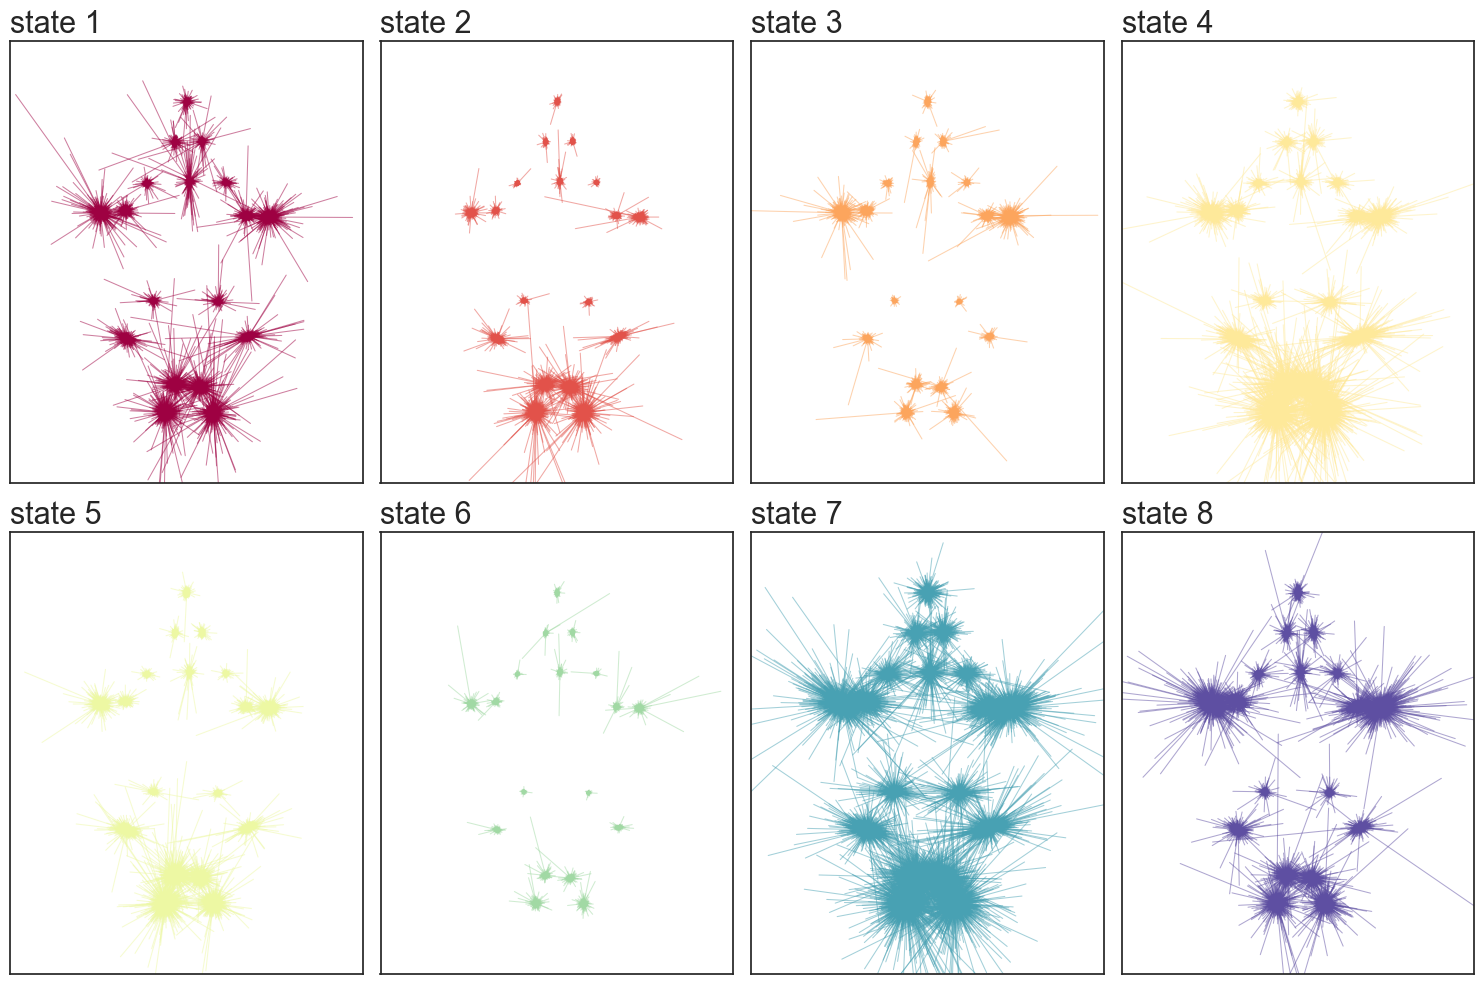

In [20]:
dx = rearrange(x_delta, 's t f -> (s t) f')
dy = rearrange(y_delta, 's t f -> (s t) f')
s = rearrange(state_space_long[:,1:], 's t -> (s t)')

fig, ax = plt.subplots(2, 4, figsize=(15,10), sharex=True, sharey=True)
num_vecs = 5000

print('plotting')
med_y = -median_position_tweak[::2]
med_x = median_position_tweak[1::2]

for n, a in enumerate(ax.reshape(-1)):
    del_x = dx[s==n, :]
    del_y = dy[s==n, :]
    
    # random subsample to reduce computation
    
    rand_idx = np.random.choice(np.arange(np.shape(del_x)[0]), size=num_vecs, replace=False)
    del_x = del_x[rand_idx, :]
    del_y = del_y[rand_idx, :]
    
    # for each (random) timestep in a given state
    # plot the movement between adjacent frames as a vector from the median position
    for i in np.arange(num_vecs):
        for f in np.arange(18):
            a.plot((med_x[f], med_x[f]+del_x[i,f]), (med_y[f], med_y[f]+del_y[i,f]), color=colors[n], lw=.75, alpha=0.5)
    
    # extras
    a.set_title('state {:}'.format(n+1), loc='left', fontsize=22)
    a.set_ylim(-120,100)
    a.set_xlim(-90,90)
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xticklabels('')
    a.set_yticklabels('')
    
plt.tight_layout()
plt.savefig('figures/vector-distribution-by-state.png', dpi=300, transparent=False)

In [21]:
# for each body part, which state contains highest velocity movements?
head_points = [0, 1, 2, 3]
arm_points = [4, 5, 6, 11, 12, 13]
leg_points = [7, 8, 9, 10, 14, 15, 16, 17]

# take top n% of high velocity frames
velocity_thr = .1
n_thr = int(4500 * velocity_thr)

# head points
head_states = []
# in each subject, count the number of high velocity frames in each state for each bp in the head
for i in np.arange(486):
    all_counts = np.zeros(8)
    for p in head_points:
        state_count = [np.sum(state_space_long[i, sorted_velocity_indices[i,:,p]][:n_thr]==n) for n in np.arange(8)]
        all_counts += state_count
    head_states.append(100*(all_counts / len(head_points)) / n_thr)

# dataframe
head_df = pd.DataFrame(head_states)
head_df.columns = ['state{:}'.format(n+1) for n in np.arange(8)]

head_df = head_df.melt(var_name='state', value_name = '% high velocity frames')
head_df.insert(0, 'points', 'head')    
    
# as above for arms
arm_states = []
for i in np.arange(486):
    all_counts = np.zeros(8)
    for p in arm_points:
        state_count = [np.sum(state_space_long[i, sorted_velocity_indices[i,:,p]][:n_thr]==n) for n in np.arange(8)]
        all_counts += state_count
    arm_states.append(100*(all_counts / len(arm_points)) / n_thr)
        
arm_df = pd.DataFrame(arm_states)
arm_df.columns = ['state{:}'.format(n+1) for n in np.arange(8)]

arm_df = arm_df.melt(var_name='state', value_name = '% high velocity frames')
arm_df.insert(0, 'points', 'arms')

# and for legs
leg_states = []
for i in np.arange(486):
    all_counts = np.zeros(8)
    for p in leg_points:
        state_count = [np.sum(state_space_long[i, sorted_velocity_indices[i,:,p]][:n_thr]==n) for n in np.arange(8)]
        all_counts += state_count
    leg_states.append(100*(all_counts / len(leg_points)) / n_thr)
    
leg_df = pd.DataFrame(leg_states)
leg_df.columns = ['state{:}'.format(n+1) for n in np.arange(8)]

leg_df = leg_df.melt(var_name='state', value_name = '% high velocity frames')
leg_df.insert(0, 'points', 'legs')

all_df = pd.concat((head_df, arm_df, leg_df))

In [22]:
# plot
fig, ax = plt.subplots(1,1,figsize=(10,4))

sns.boxplot(data=all_df, x='state', y='% high velocity frames',
              hue='points', linewidth=1, dodge=True, ax=ax, palette='Spectral', fliersize=0)
sns.stripplot(data=all_df, x='state', y='% high velocity frames', 
              hue='points', size=5,linewidth=0.5, dodge=True, ax=ax, palette='Spectral', zorder=0, legend=None)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))   
ax.set_xlabel('')

g = ax.legend()
g.set_frame_on(False)
plt.tight_layout()
plt.savefig('figures/high-velocity-frames-by-bodypoint.png', dpi=300, transparent=False)